<h1>Training Faster-RCNN for Characters Detection</h1>

<h3>installing detectron2</h3>
<p>you should restart the runtime , in order to be able to import
detectron's packges</p>

In [ ]:
!pip install pyyaml==5.1
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html

torch:  1.10 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html


Downloading UM6P dataset

In [ ]:

!wget https://msda.um6p.ma/api/upload/files/DATA.rar --no-check-certificate

--2021-12-14 20:31:25--  https://msda.um6p.ma/api/upload/files/DATA.rar
Resolving msda.um6p.ma (msda.um6p.ma)... 196.200.180.55
Connecting to msda.um6p.ma (msda.um6p.ma)|196.200.180.55|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 2653518819 (2.5G) [application/x-rar-compressed]
Saving to: ‘DATA.rar’

DATA.rar            100%[===================>]   2.47G  1012KB/s    in 43m 32s 

2021-12-14 21:14:58 (992 KB/s) - ‘DATA.rar’ saved [2653518819/2653518819]



extracting rar file

In [ ]:
!pip install patool
import patoolib
patoolib.extract_archive("DATA.rar", outdir=".")

     |████████████████████████████████| 77 kB 4.4 MB/s 
patool: Extracting /content/drive/MyDrive/DATA.rar ...
patool: running /usr/bin/unrar x -- /content/drive/MyDrive/DATA.rar
patool:     with cwd='.'
patool: ... /content/drive/MyDrive/DATA.rar extracted to `.'.


'.'

<h3>Importing detecron2 and additional packages</h3>

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

<h3>Data Loading and Prepartion for detectron2</h3>
<p> here we aimed to create a function that load annotation from csv file and 
make it ready to be consumed by Faster-RCNN model.
</p>

In [ ]:
import pandas  as pd
import os 
def get_chars_dicts(img_dir):

  classes = {"0":0,"1":1,"2":2,"3":3,"4":4,"5":5,"6":6,"7":7,"8":8,"9":9, "a":10,"b":11,"h":12,"w":13, "d":14,"ch":15,"waw":16}
  df = pd.read_csv("DATA/OCR/plates.csv", sep=";")

  

  files = df['Image name'].unique()
  files = set(files)

  
  dataset_dicts = []
  for idx, f in enumerate(files):

  
        objs = []
        record = {}

        img_chars = df[df['Image name'] == f]

    

        record["file_name"] = os.path.join(img_dir,img_chars.iloc[0,-3])
        record["image_id"] = idx
        record["height"] = img_chars.iloc[0,-1]
        record["width"] = img_chars.iloc[0,-2]
          
        for i in range(len(img_chars)):
            row = img_chars.iloc[i,:]

            x_min, y_min = row['x min'], row['y min']
            w = row['x max - x min']
            h = row['y max - ymin']

            cls = row['Class']
            obj = {
            "bbox": [x_min, y_min, w, h],
            "bbox_mode": BoxMode.XYWH_ABS,
            
            "category_id": classes[cls],
            }
    
            objs.append(obj)

        record['annotations'] = objs
        
        
        dataset_dicts.append(record)

  return dataset_dicts


<h3>DataSet Registration</h3>

In [ ]:
d = 'DATA/OCR/Plates'
DatasetCatalog.register("characters", lambda d = d: get_chars_dicts(d))
MetadataCatalog.get("characters").set(thing_classes=["0","1","2","3","4","5","6",
                                                    "7","8","9", "a","b","h","w",
                                                    "d","ch","waw"])

characters_metadata = MetadataCatalog.get("characters")

<h2>Plotting examples from Training Set</h2>

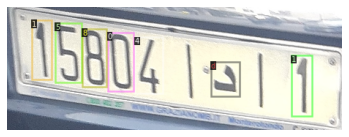

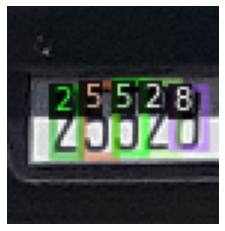

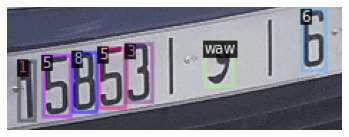

In [ ]:
import matplotlib.pyplot as plt
dataset_dicts = get_chars_dicts(d)

for dd in random.sample(dataset_dicts, 3):
   
    img = cv2.imread(dd["file_name"])

    visualizer = Visualizer(img[:, :, ::-1], metadata=characters_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(dd)
    cv2_imshow(out.get_image()[:, :, ::-1])

<h1>Trainig a Faster-RCNN Model for Characters Detection</h1>

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.MODEL.DEVICE = "cuda"

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("characters",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.MAX_ITER = 3000    # 3000 iterations seems good enough for this  dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this  dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 17 
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

cfg.OUTPUT_DIR = 'Characters_Detection_Model'

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

Loading config /usr/local/lib/python3.7/dist-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[12/20 04:59:49 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std


In [ ]:
trainer.train()

[12/20 02:58:38 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[12/20 02:59:27 d2.utils.events]:  eta: 2:02:33  iter: 19  total_loss: 2.436  loss_cls: 1.961  loss_box_reg: 0.4822  time: 2.4899  data_time: 0.0230  lr: 1.9981e-05  max_mem: 7077M
[12/20 03:00:06 d2.utils.events]:  eta: 1:42:48  iter: 39  total_loss: 1.238  loss_cls: 0.9009  loss_box_reg: 0.3221  time: 2.1861  data_time: 0.0111  lr: 3.9961e-05  max_mem: 7604M
[12/20 03:00:46 d2.utils.events]:  eta: 1:42:06  iter: 59  total_loss: 0.8075  loss_cls: 0.5806  loss_box_reg: 0.2399  time: 2.1293  data_time: 0.0096  lr: 5.9941e-05  max_mem: 7604M
[12/20 03:01:25 d2.utils.events]:  eta: 1:40:17  iter: 79  total_loss: 0.7801  loss_cls: 0.5526  loss_box_reg: 0.2247  time: 2.0801  data_time: 0.0136  lr: 7.9921e-05  max_mem: 7604M
[12/20 03:02:07 d2.utils.events]:  eta: 1:40:43  iter: 99  total_loss: 0.7863  loss_cls: 0.5531  loss_box_reg: 0.2318  time: 2.0911  data_time: 0.0114  lr: 9.9901e-05  max_mem: 7604M
[12/20 03:02:47 d2.utils.events]:  eta: 1:40:01  iter: 119  total_loss: 0.6475  loss_cls

<h1>Inference</h1>

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9   # set a custom testing threshold

predictor = DefaultPredictor(cfg)

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


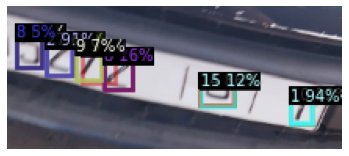

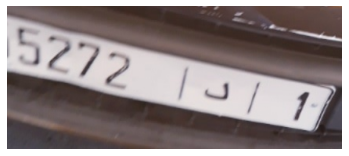

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_chars_dicts('/DATA/OCR/Plates')
for d in random.sample(dataset_dicts, 1):
     
    im = cv2.imread(d["file_name"])
  
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-form
    
    v = Visualizer(im[:, :, ::-1],
                    
                   scale=0.5, 
    )
    
    
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])
    cv2_imshow(im[:, :, ::-1])